**Item Based Collaborative Filtering**

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

Here we use MovieLens Dataset for predicting the top 10 similar movies.

In [2]:
from urllib.request import urlretrieve
import zipfile
import os
if not os.path.isfile('movielens.zip'):
    print("downloading dataset.....")
    urlretrieve("https://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip")
    zip_ref = zipfile.ZipFile('movielens.zip', "r")
    zip_ref.extractall()
    print("dataset download completed .")
else:
    print("Required files are already present.")

downloading dataset.....
dataset download completed .


In [4]:
from google.colab import files
uploaded = files.upload()

Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv


In [5]:
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(
    'u.user', sep='|', names=users_cols, encoding='ISO-8859-1')
users.head(10)

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


In [6]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'u.item', sep='|', names=movies_cols, encoding='latin-1')
movies = movies.drop(columns = 'imdb_url')
movies.head()

,movie_id,title,release_date,video_release_date,genre_unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Visulaization**

In this part we try to vizualize the total number of ratings for each unique rating.

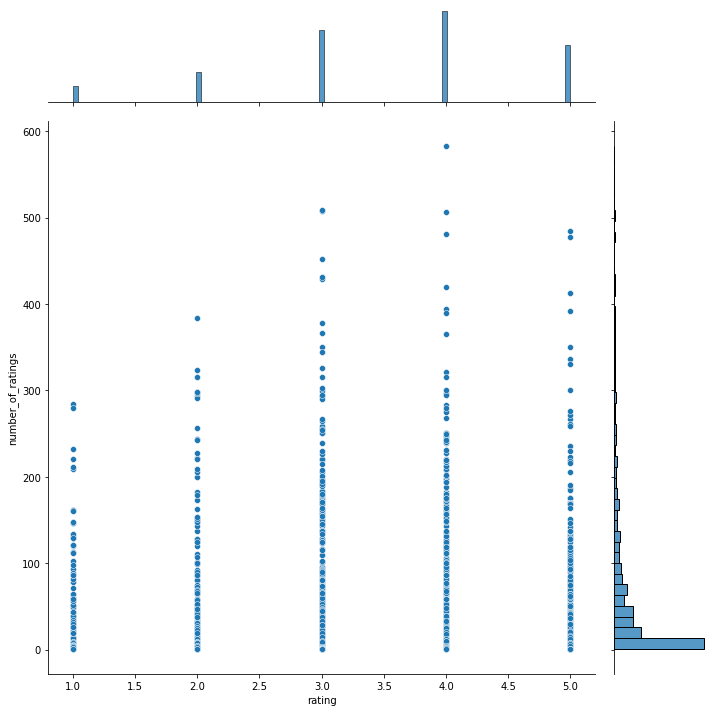

In [9]:
df = ratings.filter(['rating','movie_id'], axis = 1)

df['number_of_ratings'] = df.groupby('movie_id')['rating'].count()

import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=df, height = 10)

In [10]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,genre_unknown,Action,Adventure,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,0,0,0,...,0,0,0,0,0,0,49,M,writer,55105
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,NaN,0,1,1,...,0,0,1,0,0,0,49,M,writer,55105
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,0,0,0,...,0,1,0,0,0,0,49,M,writer,55105
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,0,0,0,...,0,0,0,0,0,0,49,M,writer,55105
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,0,0,0,...,0,0,0,0,0,0,49,M,writer,55105


In [14]:
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)


def filtered_hist(field, label, filter):
    """Creates a layered chart of histograms.
    The first layer (light gray) contains the histogram of the full data, and the
    second contains the histogram of the filtered data.
    """
    base = alt.Chart().mark_bar().encode(
        x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
        y="count()",
    ).properties(
        width=300,
    )
    return alt.layer(
        base.transform_filter(filter),
        base.encode(color=alt.value('lightgreen'), opacity=alt.value(.7)),
    ).resolve_scale(y='independent')


def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df
pd.DataFrame.flatten_cols = flatten_cols
#function for multipurpose use
def mask(df, key, function):
    return df[function(df[key])]
pd.DataFrame.mask = mask

In [15]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

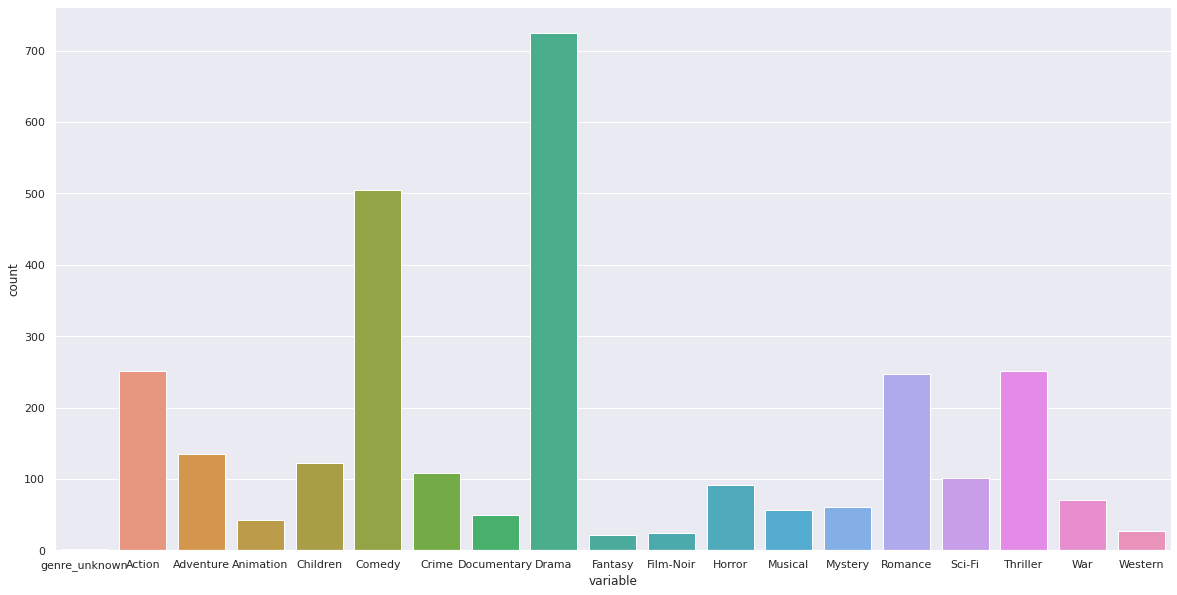

In [16]:
sns.set(rc={'figure.figsize':(20,10)})
genre_occurences = movies[genre_cols].sum().to_dict()


df2 = movies.melt(value_vars=genre_cols)
df2 = df2[df2["value"] != 0]
sns.countplot(data=df2, x="variable")

Item Based Filtering

In [17]:
cols = list(ratings.columns)
cols.remove('unix_timestamp')


rating = pd.merge(ratings[cols], movies[['title','movie_id']])
rating.head()

,user_id,movie_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [18]:
userRatings = rating.pivot_table(index=['user_id'],columns=['title'],values='rating')
userRatings.head()


title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [19]:
corrMatrix = userRatings.corr()
corrMatrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1.0,NaN,-1.000000,-0.500000,-0.500000,0.522233,NaN,-0.426401,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,1.0,NaN,NaN,NaN,NaN,NaN,-0.981981,NaN,NaN,...,NaN,NaN,NaN,-0.944911,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),-1.0,NaN,1.000000,-0.049890,0.269191,0.048973,0.266928,-0.043407,NaN,0.111111,...,NaN,-1.000000,NaN,0.158840,0.119234,0.680414,-4.875600e-17,0.707107,NaN,NaN
12 Angry Men (1957),-0.5,NaN,-0.049890,1.000000,0.666667,0.256625,0.274772,0.178848,NaN,0.457176,...,NaN,NaN,NaN,0.096546,0.068944,-0.361961,1.443376e-01,1.000000,1.0,NaN
187 (1997),-0.5,NaN,0.269191,0.666667,1.000000,0.596644,NaN,-0.554700,NaN,1.000000,...,NaN,0.866025,NaN,0.455233,-0.500000,0.500000,4.753271e-01,NaN,NaN,NaN


In [47]:
myRatings = userRatings.loc[20].dropna()
myRatings


title
African Queen, The (1951)                       3.0
Aladdin (1992)                                  3.0
Aliens (1986)                                   2.0
Back to the Future (1985)                       3.0
Beauty and the Beast (1991)                     4.0
Blues Brothers, The (1980)                      3.0
Braveheart (1995)                               5.0
Christmas Carol, A (1938)                       4.0
Dante's Peak (1997)                             4.0
Die Hard (1988)                                 2.0
E.T. the Extra-Terrestrial (1982)               2.0
Empire Strikes Back, The (1980)                 3.0
Eraser (1996)                                   3.0
Forrest Gump (1994)                             1.0
Ghost and the Darkness, The (1996)              5.0
Happy Gilmore (1996)                            1.0
Home Alone (1990)                               2.0
Independence Day (ID4) (1996)                   3.0
Indiana Jones and the Last Crusade (1989)       4.0
Island

We  will try to find the similarity for user 20

In [48]:

simCandidates = pd.Series(dtype = 'float64')

for i in range(0, len(myRatings.index)):

    sims = corrMatrix[myRatings.index[i]].dropna()
    sims = sims.map(lambda x: x * myRatings[i])
    simCandidates = simCandidates.append(sims)
     
simCandidates.sort_values(inplace = True, ascending = False)
print (simCandidates.head(10))

Hard Eight (1996)                                       5.0
Nina Takes a Lover (1994)                               5.0
Little Rascals, The (1994)                              5.0
Great Race, The (1965)                                  5.0
Original Gangstas (1996)                                5.0
Prisoner of the Mountains (Kavkazsky Plennik) (1996)    5.0
Beat the Devil (1954)                                   5.0
Ponette (1996)                                          5.0
Pompatus of Love, The (1996)                            5.0
Perfect Candidate, A (1996)                             5.0
dtype: float64


In [49]:
simCandidates.sort_values(inplace = True, ascending = False)
simCandidates.head(10)

Hard Eight (1996)             5.0
Great Race, The (1965)        5.0
Nina Takes a Lover (1994)     5.0
Little Rascals, The (1994)    5.0
Women, The (1939)             5.0
Radioland Murders (1994)      5.0
Carrington (1995)             5.0
Burnt Offerings (1976)        5.0
Tie That Binds, The (1995)    5.0
Street Fighter (1994)         5.0
dtype: float64

In [50]:

filteredSims = simCandidates.drop(myRatings.index)
filteredSims.head(10)

Hard Eight (1996)             5.0
Great Race, The (1965)        5.0
Nina Takes a Lover (1994)     5.0
Little Rascals, The (1994)    5.0
Women, The (1939)             5.0
Radioland Murders (1994)      5.0
Carrington (1995)             5.0
Burnt Offerings (1976)        5.0
Tie That Binds, The (1995)    5.0
Street Fighter (1994)         5.0
dtype: float64

Finding the RMSE score for Item based Filtering

In [51]:

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()

data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)



Splitting the data to train and test

In [52]:
from surprise.model_selection import train_test_split

In [53]:
trainset, testset = train_test_split(data, test_size=0.2)

In [54]:
trainsetfull = data.build_full_trainset()

In [55]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  943 

Number of items:  1647 



In [56]:
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

Uses KNNWithMeans algorithm to find the RMSE Score

In [57]:
from surprise import KNNWithMeans
my_k = 15
my_min_k = 5
my_sim_option = {
    'name':'pearson', 'user_based':False, 
    }
algo = KNNWithMeans(
    k = my_k, min_k = my_min_k, sim_option = my_sim_option
    )
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [58]:
from surprise import accuracy
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9595


0.9594544271599772

In [59]:
from surprise.model_selection import cross_validate
results = cross_validate(
    algo = algo, data = data, measures=['RMSE'], 
    cv=5, return_train_measures=True
    )

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [60]:
results['test_rmse'].mean()

0.9625581405526542

In [61]:
algo.fit(trainsetfull)

Computing the msd similarity matrix...
Done computing similarity matrix.
